In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import random
import torch.nn as nn
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

### Глобальные параметры

In [13]:
SEED = 7
pl.seed_everything(SEED)
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

Seed set to 7


### Параметры обучения

In [14]:
BATCH_SIZE = 40
EPOCHS = 4000
LR = 2e-4
B1 = 0.5
B2= 0.999
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Пути

In [15]:
DATASET_PATH = "../Datasets/LUDB/i_ii_avf_v4_v5_v6_one_complex.json"
MODEL_PATH = "../Models/OneComplex/Lightning/Denoised/"
LOG_PATH = "../Logs/OneComplex/Lightning/Denoised/"
CHECKPOINT_PATH = "../Models/OneComplex/Lightning/Denoised/last.ckpt"

### Параметры модели

In [16]:
DISCRIMINATOR_INPUT_SIZE = 256
DATA = pd.read_json(DATASET_PATH)

### Модуль данных

In [17]:
class ECGDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size=1,
        data=None,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.data = data

    def setup(self, stage=None):
        self.train_set = TensorDataset(
            torch.Tensor(self.data),
            torch.ones_like(torch.Tensor(self.data)))        

    def train_dataloader(self):
        return DataLoader(self.train_set,
                          batch_size=self.batch_size,
                          shuffle=True,
                          drop_last=True)


### Дискриминатор

In [18]:
class Discriminator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(Discriminator, self).__init__()

      self.discriminator_input_size = discriminator_input_size
      self.model = torch.nn.Sequential(
          torch.nn.Linear(self.discriminator_input_size, 512),
          torch.nn.LeakyReLU(0.2, inplace=True),
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(0.2, inplace=True),
          torch.nn.Linear(256, 1),
          torch.nn.Sigmoid(),
      )

    def forward(self, x):
        out = self.model(x)
        return out

### Генератор с фильтрацией

In [19]:
class DenoisedGenerator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(DenoisedGenerator, self).__init__()

      self.discriminator_input_size = discriminator_input_size

      self.model = torch.nn.Sequential(
          torch.nn.Linear(100, 128),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(128, 256),
          torch.nn.BatchNorm1d(256, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(256, 512),
          torch.nn.BatchNorm1d(512, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(512, 1024),
          torch.nn.BatchNorm1d(1024, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(1024, self.discriminator_input_size),
          torch.nn.Tanh(),
      )
      self.convs_1d = torch.nn.Sequential(
          torch.nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 1, kernel_size=9, stride=1, padding=4))

    def forward(self, x):
        out = self.model(x)
        out = out.unsqueeze(1)
        out = self.convs_1d(out)
        out = out.squeeze()
        return out

### Модель с фильтрацией

In [20]:
class DenoisedGAN(pl.LightningModule):
    def __init__(self,
                 discriminator_input_size=256,
                 lr=0.0002,
                 b1=0.5,
                 b2=0.999,
                 is_denoised = False):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.preds_stage = {"train": {"g_loss": [], "d_loss": []}}

        self.discriminator_input_size = discriminator_input_size
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.loss = torch.nn.BCELoss()

        self.generator = DenoisedGenerator(discriminator_input_size)
        self.discriminator = Discriminator(discriminator_input_size)
        
        

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        return [opt_g, opt_d], []

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        optg, optd = self.optimizers()

        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1], device=self.device)
        g_loss = self.loss(fake_outputs, fake_targets)
        self.preds_stage['train']['g_loss'].append(g_loss.detach().cpu())
        optg.zero_grad()
        g_loss.backward()
        optg.step()


        real_outputs = self.discriminator(imgs)
        real_label = torch.ones(imgs.shape[0], 1, device=self.device)
        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1, device=self.device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        d_loss = self.loss(outputs, targets)
        self.preds_stage['train']['d_loss'].append(d_loss.detach().cpu())
        optd.zero_grad()
        d_loss.backward()
        optd.step()

    def on_train_epoch_end(self):
        g_loss = self.preds_stage['train']['g_loss']
        g_loss = torch.stack(g_loss)
        g_loss = np.mean([x.item() for x in g_loss])

        d_loss = self.preds_stage['train']['d_loss']
        d_loss = torch.stack(d_loss)
        d_loss = np.mean([x.item() for x in d_loss])

        metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss
        }
        self.log_dict(metrics, prog_bar=True, on_epoch=True, on_step=False)

        self.preds_stage['train']['g_loss'].clear()
        self.preds_stage['train']['d_loss'].clear()

### Обучение модели

In [21]:
dm = ECGDataModule(BATCH_SIZE, DATA["ecg"])
dm.prepare_data()
dm.setup()

In [22]:
model = DenoisedGAN(discriminator_input_size=DISCRIMINATOR_INPUT_SIZE, lr=LR, b1=B1, b2=B2)

callbacks = [
    ModelCheckpoint(
        dirpath=MODEL_PATH,
        filename='{epoch}_{g_loss:.2f}_{d_loss:.2f}',
        save_top_k=5,
        monitor="epoch",
        mode="max",
        every_n_epochs=1000,
        save_last=True)
]

logger = TensorBoardLogger(LOG_PATH, name="LUDB_ECG")


trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=EPOCHS,
                     logger=logger,
                     callbacks=callbacks)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, dm, ckpt_path=CHECKPOINT_PATH)

d:\random\JupiterProjects\ECGResults\.venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory D:\random\JupiterProjects\ECGResults\Models\OneComplex\Lightning\Denoised exists and is not empty.
Restoring states from the checkpoint path at ../Models/OneComplex/Lightning/Denoised/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | loss          | BCELoss           | 0     
1 | generator     | DenoisedGenerator | 971 K 
2 | discriminator | Discriminator     | 263 K 
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.939     Total estimated model params size (MB)
Restored all states from the checkpoint at ../Models/OneComplex/Lightning/Denoised/last.ckpt
d:\random\JupiterProjects\ECGResults\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connecto

Epoch 3999: 100%|██████████| 89/89 [00:01<00:00, 80.20it/s, v_num=7, g_loss=3.150, d_loss=0.145]

`Trainer.fit` stopped: `max_epochs=4000` reached.


Epoch 3999: 100%|██████████| 89/89 [00:01<00:00, 74.70it/s, v_num=7, g_loss=3.150, d_loss=0.145]


### Результаты

In [24]:
denoised_generator = DenoisedGAN.load_from_checkpoint(CHECKPOINT_PATH).cpu()
denoised_generator.eval()
num_samples = 10
noise = torch.normal(0, 1, size=(num_samples, 100))
denoised_generated_ecg = denoised_generator(noise).detach().cpu()

In [25]:
ludb_random_samples = random.choices(DATA["ecg"], k=num_samples)

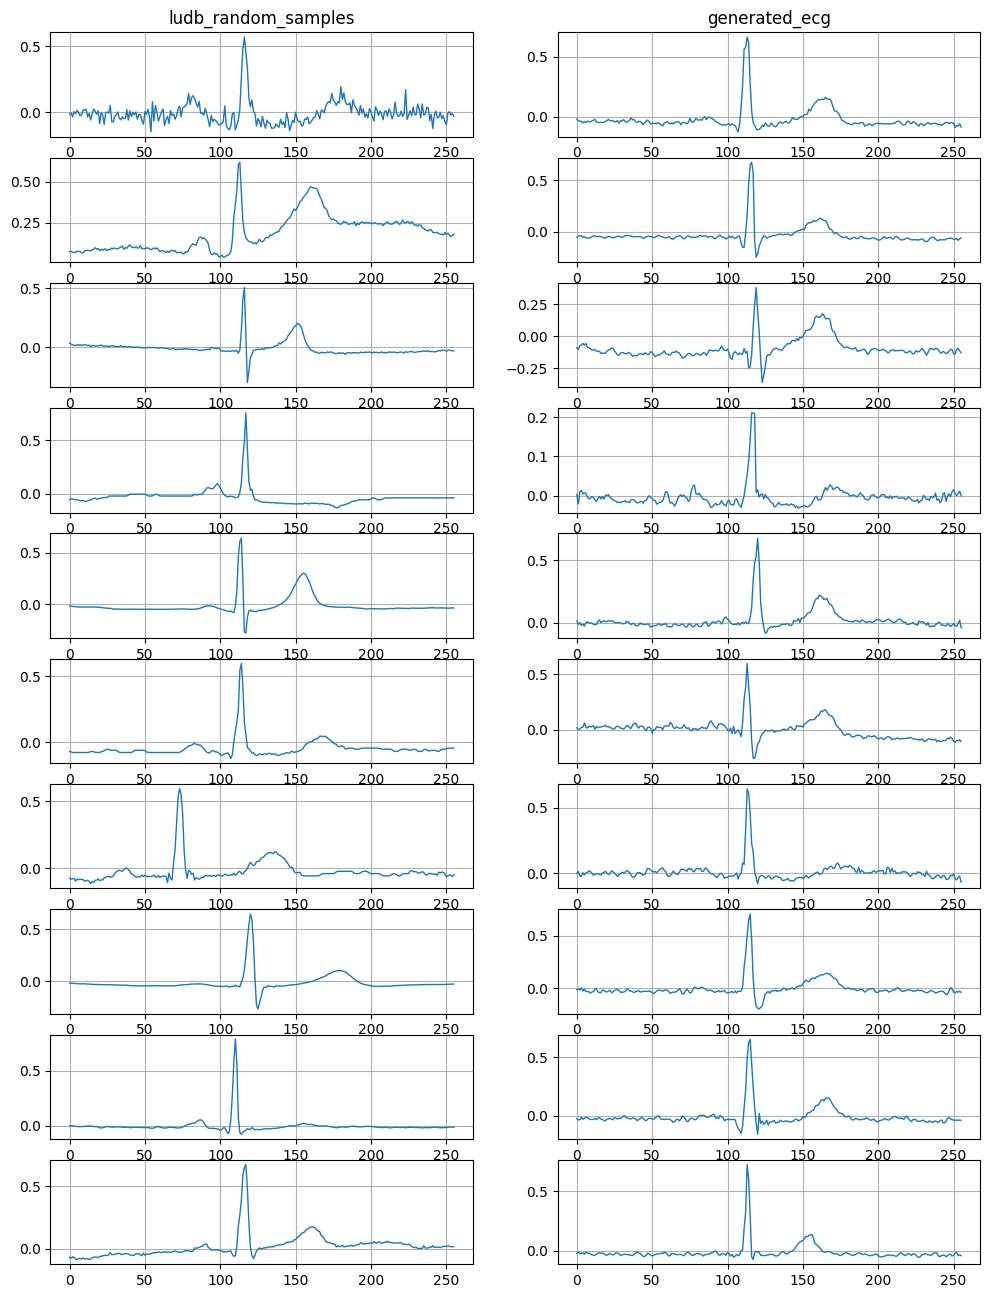

In [26]:
n_cols = 2
n_rows = num_samples

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 16))

axes[0, 0].set_title(f"ludb_random_samples")
axes[0, 1].set_title(f"generated_ecg")


for i in range(n_rows):
    axes[i, 0].plot(ludb_random_samples[i])
    axes[i, 1].plot(denoised_generated_ecg[i])
